First we look at the problem of determining whether or not a pharmacy claim will be approved. There are various columns in the data, our first goal will be to determine which factors contribute significantly to the claim approval.


In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

In [152]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [153]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (2).csv


In [154]:
import io
data = pd.read_csv(io.BytesIO(uploaded['train.csv']),index_col=1, parse_dates=True)

There are some columns in the data which are obviously unrelated to claim approval. For example, columns like 'correct_diagnosis', 'reject_code' etc. So we remove these columns when considering the problem of predicting pharmacy claim approval. 

In [155]:
pa_columns = ['correct_diagnosis','tried_and_failed','contraindication','pa_approved','reject_code']
id_columns = ['dim_pa_id','dim_date_id','dim_claim_id','Unnamed: 0']
date_columns = ['calendar_year']
data = data.drop(columns=pa_columns+id_columns+date_columns)
data = data.dropna()

Next we check whether temporal features like calendar month or calendar day or factors like weekday, workday or holiday seem to affect chances of claim approval. 

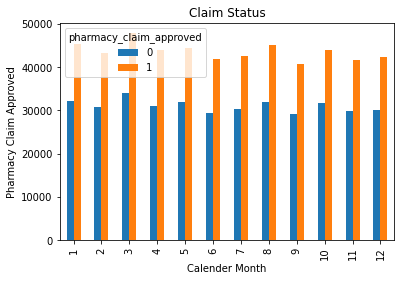

In [156]:
pd.crosstab(data.calendar_month,data.pharmacy_claim_approved).plot(kind='bar')
plt.title('Claim Status')
plt.xlabel('Calender Month')
plt.ylabel('Pharmacy Claim Approved')
plt.savefig('calender_month')

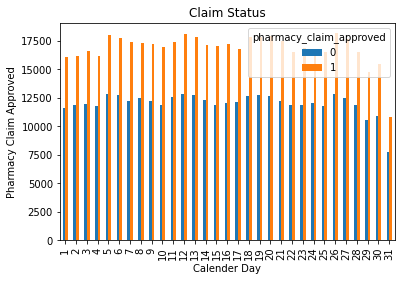

In [157]:
pd.crosstab(data.calendar_day,data.pharmacy_claim_approved).plot(kind='bar')
plt.title('Claim Status')
plt.xlabel('Calender Day')
plt.ylabel('Pharmacy Claim Approved')
plt.savefig('calender_day')

Looking at the bar plots of claims approved versus calender month or day, we see that even though the total number of claims vary depending on month or day, the proportion of claims that do get approved are fairly constant.

Let's now check if this proportion of approved claims varies a lot on whether it comes in on a weekday, holiday etc.

First, drop the day and month columns.

In [158]:
data=data.drop(columns='calendar_month')
data=data.drop(columns='calendar_day')

In [159]:
data

,day_of_week,is_weekday,is_workday,is_holiday,bin,drug,pharmacy_claim_approved
date_val,,,,,,,
2017-04-07,6,1,1,0,999001,A,1
2017-01-30,2,1,1,0,999001,C,1
2019-11-11,2,1,1,0,417740,B,0
2019-06-28,6,1,1,0,999001,A,0
2017-02-27,2,1,1,0,999001,A,1
...,...,...,...,...,...,...,...
2017-04-11,3,1,1,0,417380,C,0
2017-09-03,1,0,0,0,999001,A,1
2017-05-02,3,1,1,0,999001,A,1


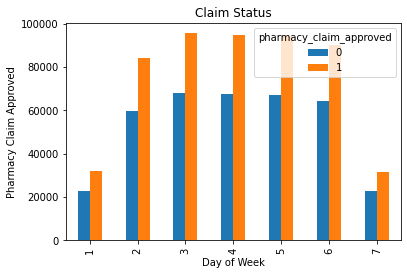

In [160]:
pd.crosstab(data.day_of_week,data.pharmacy_claim_approved).plot(kind='bar')
plt.title('Claim Status')
plt.xlabel('Day of Week')
plt.ylabel('Pharmacy Claim Approved')
plt.savefig('day_of_week')

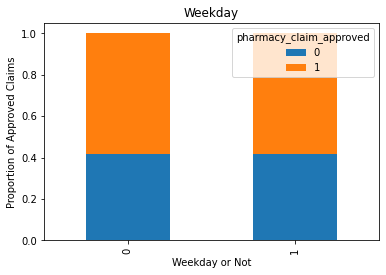

In [161]:
table=pd.crosstab(data.is_weekday,data.pharmacy_claim_approved)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Weekday')
plt.xlabel('Weekday or Not')
plt.ylabel('Proportion of Approved Claims')
plt.savefig('Weekday')

Looking at the 'weekday or not' and 'day of week' plots, we see that proportion of approved claims varies somewhat (but not a lot) with these features. We keep the weekday, workday, holiday colums for now.

We need to encode the categorical variables like bin, drug, day of week.

In [162]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['bin', 'drug','day_of_week'])

In [163]:
one_hot_encoded_data

,is_weekday,is_workday,is_holiday,pharmacy_claim_approved,bin_417380,bin_417614,bin_417740,bin_999001,drug_A,drug_B,drug_C,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
date_val,,,,,,,,,,,,,,,,,,
2017-04-07,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
2017-01-30,1,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
2019-11-11,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
2019-06-28,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0
2017-02-27,1,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-11,1,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
2017-09-03,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0
2017-05-02,1,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0


In [164]:
X = one_hot_encoded_data.loc[:, one_hot_encoded_data.columns != 'pharmacy_claim_approved']
y = one_hot_encoded_data.loc[:, one_hot_encoded_data.columns == 'pharmacy_claim_approved']

Our target variable is of course the pharmacy_claim_approved column, so we separate the data into target and predictor variables.

For the one-hat-encoded columns bin, drug and day of week, we need to be careful. Encoding these columns means each of the encoded columns is expressed with respect to a fixed one. To make sure there is no linear dependence in the encoded columns, we drop one column for each. In particular, we drop 'drug_A' for the drug, 'bin_417380' for bin and 'day_of_week_1' for day of week. By dropping one of the one-hot encoded columns from each categorical feature, we ensure there are no "reference" columns—the remaining columns become linearly independent.

In [165]:
X=X.drop('bin_417380',1)

In [166]:
X=X.drop('drug_A',1)

In [167]:
X=X.drop('day_of_week_1',1)

In [168]:
X

,is_weekday,is_workday,is_holiday,bin_417614,bin_417740,bin_999001,drug_B,drug_C,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
date_val,,,,,,,,,,,,,,
2017-04-07,1,1,0,0,0,1,0,0,0,0,0,0,1,0
2017-01-30,1,1,0,0,0,1,0,1,1,0,0,0,0,0
2019-11-11,1,1,0,0,1,0,1,0,1,0,0,0,0,0
2019-06-28,1,1,0,0,0,1,0,0,0,0,0,0,1,0
2017-02-27,1,1,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-11,1,1,0,0,0,0,0,1,0,1,0,0,0,0
2017-09-03,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2017-05-02,1,1,0,0,0,1,0,0,0,1,0,0,0,0


In [169]:
y

,pharmacy_claim_approved
date_val,
2017-04-07,1
2017-01-30,1
2019-11-11,0
2019-06-28,0
2017-02-27,1
...,...
2017-04-11,0
2017-09-03,1
2017-05-02,1


Let us now try to fit Logistic Regression with the features we have at this stage. The logit model will also give us p-values corresponding to each feature, and we may decide based on the p-values whether a feature is significant.

First let's use k-fold cross-validation with k=5 to split our data into train and holdout sets.

In [170]:
from sklearn.model_selection import KFold 

In [171]:
kfold = KFold(n_splits=5, 
                 shuffle = True,
                 random_state=614)

In [172]:
kfold.split(X, y)

<generator object _BaseKFold.split at 0x7f54bde57d50>

In [173]:
for train_index, test_index in kfold.split(X, y):
    X_train = X.iloc[train_index,:]
    y_train = y.iloc[train_index]
    X_holdout = X.iloc[test_index,:]
    y_holdout = y.iloc[test_index]

In [174]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.457595
         Iterations 8
                              Results: Logit
Model:               Logit                   Pseudo R-squared: 0.326      
Dependent Variable:  pharmacy_claim_approved AIC:              655181.2506
Date:                2021-11-27 21:56        BIC:              655330.5069
No. Observations:    715868                  Log-Likelihood:   -3.2758e+05
Df Model:            12                      LL-Null:          -4.8607e+05
Df Residuals:        715855                  LLR p-value:      0.0000     
Converged:           1.0000                  Scale:            1.0000     
No. Iterations:      8.0000                                               
--------------------------------------------------------------------------
               Coef.    Std.Err.     z     P>|z|     [0.025       0.975]  
--------------------------------------------------------------------------
is_weekday    -0.7901 119915

Lookin at the p-values, it's pretty apparent that the 'is_weekday', 'is_workday', 'is_holiday' and 'day_of_week' features are not significant. There seems to be dependance on whether the claim comes in on a Sunday (that may be why the p-value is great for day_of_week_7').

So we drop the rest of the columns.

In [175]:
X_train=X_train.drop(columns='day_of_week_2')
X_train=X_train.drop(columns='day_of_week_3')
X_train=X_train.drop(columns='day_of_week_4')
X_train=X_train.drop(columns='day_of_week_5')
X_train=X_train.drop(columns='day_of_week_6')
X_train=X_train.drop(columns='is_weekday')
X_train=X_train.drop(columns='is_workday')
X_train=X_train.drop(columns='is_holiday')

In [176]:
X_train

,bin_417614,bin_417740,bin_999001,drug_B,drug_C,day_of_week_7
date_val,,,,,,
2017-04-07,0,0,1,0,0,0
2017-01-30,0,0,1,0,1,0
2019-11-11,0,1,0,1,0,0
2019-06-28,0,0,1,0,0,0
2017-02-27,0,0,1,0,0,0
...,...,...,...,...,...,...
2019-07-07,0,0,1,1,0,0
2018-10-03,0,1,0,0,0,0
2017-04-11,0,0,0,0,1,0


Let's now run the logistic regression model again on the remaining features.

In [177]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.470652
         Iterations 6
                             Results: Logit
Model:              Logit                   Pseudo R-squared: 0.307      
Dependent Variable: pharmacy_claim_approved AIC:              673861.1419
Date:               2021-11-27 21:57        BIC:              673930.0294
No. Observations:   715868                  Log-Likelihood:   -3.3692e+05
Df Model:           5                       LL-Null:          -4.8607e+05
Df Residuals:       715862                  LLR p-value:      0.0000     
Converged:          1.0000                  Scale:            1.0000     
No. Iterations:     6.0000                                               
---------------------------------------------------------------------------
                 Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
---------------------------------------------------------------------------
bin_417614      -1.1806     0.0066

The p-values now are all very good, so we go ahead and fit our model and try to evaluate it on the holdout data.

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [179]:
logreg = LogisticRegression()

In [180]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [181]:
X_holdout=X_holdout.drop(columns='day_of_week_2')
X_holdout=X_holdout.drop(columns='day_of_week_3')
X_holdout=X_holdout.drop(columns='day_of_week_4')
X_holdout=X_holdout.drop(columns='day_of_week_5')
X_holdout=X_holdout.drop(columns='day_of_week_6')
X_holdout=X_holdout.drop(columns='is_weekday')
X_holdout=X_holdout.drop(columns='is_workday')
X_holdout=X_holdout.drop(columns='is_holiday')

In [182]:
y_predholdout = logreg.predict(X_holdout)

In [183]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_holdout, y_holdout)))

Accuracy of logistic regression classifier on test set: 0.76


We see that the logistic regression model based on the chosen features gives us an accuracy of 0.76 on the holdout data.

What about the accuracy when working on the test data itself?

In [184]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [185]:
import io
testdata = pd.read_csv(io.BytesIO(uploaded['test.csv']),index_col=1, parse_dates=True)

In [186]:
pa_columns = ['correct_diagnosis','tried_and_failed','contraindication','pa_approved','reject_code']
id_columns = ['dim_pa_id','dim_date_id','dim_claim_id','Unnamed: 0']
date_columns = ['calendar_year']
testdata = testdata.drop(columns=pa_columns+id_columns+date_columns)
testdata = testdata.dropna()
testdata=testdata.drop(columns='calendar_month')
testdata=testdata.drop(columns='calendar_day')

In [187]:
testdata=testdata.drop(columns='is_weekday')

In [188]:
testdata=testdata.drop(columns='is_workday')

In [189]:
testdata=testdata.drop(columns='is_holiday')

In [190]:
one_hot_encoded_testdata = pd.get_dummies(testdata, columns = ['bin', 'drug','day_of_week'])

In [191]:
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='day_of_week_1')
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='day_of_week_2')
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='day_of_week_3')
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='day_of_week_4')
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='day_of_week_5')
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='day_of_week_6')
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='bin_417380')
one_hot_encoded_testdata=one_hot_encoded_testdata.drop(columns='drug_A')

In [192]:
one_hot_encoded_testdata

,pharmacy_claim_approved,bin_417614,bin_417740,bin_999001,drug_B,drug_C,day_of_week_7
date_val,,,,,,,
2018-01-10,1,0,0,1,0,0,0
2019-02-07,1,0,0,1,0,0,0
2019-08-16,0,0,1,0,1,0,0
2018-12-11,1,0,0,1,0,0,0
2018-04-14,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...
2019-07-16,1,0,0,1,0,0,0
2018-11-16,1,0,0,1,0,0,0
2019-03-01,1,0,0,1,0,0,0


In [193]:
X_test = one_hot_encoded_testdata.loc[:, one_hot_encoded_testdata.columns != 'pharmacy_claim_approved']

In [194]:
y_test = one_hot_encoded_testdata.loc[:, one_hot_encoded_testdata.columns == 'pharmacy_claim_approved']

In [195]:
X_test

,bin_417614,bin_417740,bin_999001,drug_B,drug_C,day_of_week_7
date_val,,,,,,
2018-01-10,0,0,1,0,0,0
2019-02-07,0,0,1,0,0,0
2019-08-16,0,1,0,1,0,0
2018-12-11,0,0,1,0,0,0
2018-04-14,0,0,0,1,0,1
...,...,...,...,...,...,...
2019-07-16,0,0,1,0,0,0
2018-11-16,0,0,1,0,0,0
2019-03-01,0,0,1,0,0,0


In [196]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [197]:
y_pred = logreg.predict(X_test)

In [198]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


We see the model gives the same accuracy of 76% on the test data as well.

A key takeaway is that the only important features affecting pharamacy claim approval are the bin and drug columns.

We list the important metrics for the prediction based on the train data on the holdout set.

In [199]:
from sklearn.metrics import roc_auc_score
print("Accuracy:",metrics.accuracy_score(y_holdout, y_predholdout))
print("F 1 Score:",metrics.f1_score(y_holdout, y_predholdout))
print("Precision Score:",metrics.precision_score(y_holdout, y_predholdout))
print("Recall Score:",metrics.recall_score(y_holdout, y_predholdout))
print("ROC AUC score:",roc_auc_score(y_holdout, y_predholdout))

Accuracy: 0.7619002385914722
F 1 Score: 0.78415342066073
Precision Score: 0.8342818340554873
Recall Score: 0.7397075688073395
ROC AUC score: 0.7664256896332633


Next we list the values of these same metrics when predicting on the test data.

In [200]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F 1 Score:",metrics.f1_score(y_test, y_pred))
print("Precision Score:",metrics.precision_score(y_test, y_pred))
print("Recall Score:",metrics.recall_score(y_test, y_pred))
print("ROC AUC score:",roc_auc_score(y_test, y_pred))

Accuracy: 0.7635368617850393
F 1 Score: 0.7851593179948834
Precision Score: 0.8348091388893759
Recall Score: 0.7410837630119661
ROC AUC score: 0.7680093129133163


The metric values are pretty similar for the holdout and test sets, as expected.

Now let's check whether the metrics suffer if we drop the weekday_7 column as well.

In [201]:
X_train=X_train.drop(columns='day_of_week_7')
X_test=X_test.drop(columns='day_of_week_7')
X_holdout=X_holdout.drop(columns='day_of_week_7')

In [202]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [203]:
y_predholdout = logreg.predict(X_holdout)
y_pred = logreg.predict(X_test)

In [204]:
print("Accuracy:",metrics.accuracy_score(y_holdout, y_predholdout))
print("F 1 Score:",metrics.f1_score(y_holdout, y_predholdout))
print("Precision Score:",metrics.precision_score(y_holdout, y_predholdout))
print("Recall Score:",metrics.recall_score(y_holdout, y_predholdout))
print("ROC AUC score:",roc_auc_score(y_holdout, y_predholdout))

Accuracy: 0.7619002385914722
F 1 Score: 0.78415342066073
Precision Score: 0.8342818340554873
Recall Score: 0.7397075688073395
ROC AUC score: 0.7664256896332633


In [205]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("F 1 Score:",metrics.f1_score(y_test, y_pred))
print("Precision Score:",metrics.precision_score(y_test, y_pred))
print("Recall Score:",metrics.recall_score(y_test, y_pred))
print("ROC AUC score:",roc_auc_score(y_test, y_pred))

Accuracy: 0.7635368617850393
F 1 Score: 0.7851593179948834
Precision Score: 0.8348091388893759
Recall Score: 0.7410837630119661
ROC AUC score: 0.7680093129133163


The metric values are almost exactly the same as before, and as such we can build our model using only bin and drug columns as our significant features. This validates the bar plots we obtained towards the beginning of this notebook.